# Resume Parsing

## 1. Load data

In [2]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv('../../data/resume.csv')

In [3]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]  #optional if your computer is fast, no need
df_resume.shape

(1000, 4)

## 2. Load skill data

Spacy allows you to give a list of words, then it will automatically create pattern.

In [5]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = "../../data/skills.jsonl"

In [6]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [7]:
doc = nlp("Chaky loves deep learning.")
doc.ents

(Chaky, deep learning)

## 3. Extracting skills from resume.csv

In [10]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
1803,31694970,INDUSTRIAL ENGINEERING INTERN P...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING
630,20317319,BUSINESS DEVELOPMENT ASSOCIATE ...,"<div class=""fontsize fontface vmargins hmargin...",BUSINESS-DEVELOPMENT
2320,27936502,PACKAGING BUYER/RESEARCH AND DEVELOPM...,"<div class=""fontsize fontface vmargins hmargin...",ARTS
2318,16962067,AS K-12 PRINCIPAL Pr...,"<div class=""LCA skn-mlt6 fontsize fontface vma...",ARTS
2023,30311725,SENIOR PROJECT MANAGER Professi...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION


In [11]:
from spacy.lang.en.stop_words import STOP_WORDS

#before that, let's clean our resume.csv dataframe
def preprocessing(sentence):
    
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

In [13]:
#random sampling
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         FREELANCE GRAPHIC DESIGNER           Highlights          Summary:\tMarketing and design professional with nearly eight years experience supporting effective development and implementation of company marketing plan and goals. Areas of expertise include:  Development of brand identity  Layout '

In [14]:
preprocessing(random_resume[:300])

'freelance graphic designer highlight summary marketing design professional nearly year experience support effective development implementation company marketing plan goal area expertise include development brand identity layout'

In [15]:
#let's apply to the whole dataframe
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [16]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
1803,31694970,INDUSTRIAL ENGINEERING INTERN P...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING,industrial engineering intern profile outstand...
630,20317319,BUSINESS DEVELOPMENT ASSOCIATE ...,"<div class=""fontsize fontface vmargins hmargin...",BUSINESS-DEVELOPMENT,business development associate summary hungry ...
2320,27936502,PACKAGING BUYER/RESEARCH AND DEVELOPM...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,package buyer research and development lead su...
2318,16962067,AS K-12 PRINCIPAL Pr...,"<div class=""LCA skn-mlt6 fontsize fontface vma...",ARTS,as k-12 principal professional summary committ...
2023,30311725,SENIOR PROJECT MANAGER Professi...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,senior project manager professional summary am...


## 4. Let's really extract skills!!

In [17]:
def get_skills(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills
    
    skills = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "SKILL":
            skills.append(ent.text)
    
    return skills

def unique_skills(x):
    return list(set(x))

In [18]:
df_resume.head(1)

,ID,Resume_str,Resume_html,Category,Clean_resume
1803,31694970,INDUSTRIAL ENGINEERING INTERN P...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING,industrial engineering intern profile outstand...


In [20]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [21]:
df_resume.Skills.iloc[0]

['simulation',
 'engineering',
 'documentation',
 'throughput',
 'material',
 'languages',
 'specification',
 'support',
 'manufacturing engineering',
 'visual basic',
 'design',
 'project management',
 'discrete event simulation',
 'component',
 'computation',
 'schedule',
 'industrial engineering',
 'visual studio']

## 5. Visualization

Which skills is most important in information management?

In [22]:
set(df_resume.Category)

{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [23]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(54, 6)

In [24]:
all_skill = np.concatenate(df_resume_it.Skills.values)

In [25]:
#counting
from collections import Counter, OrderedDict

counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

In [26]:
counting

OrderedDict([('support', 48),
             ('software', 46),
             ('design', 42),
             ('business', 38),
             ('security', 32),
             ('server', 31),
             ('windows', 28),
             ('database', 24),
             ('documentation', 23),
             ('project management', 23)])

<BarContainer object of 10 artists>

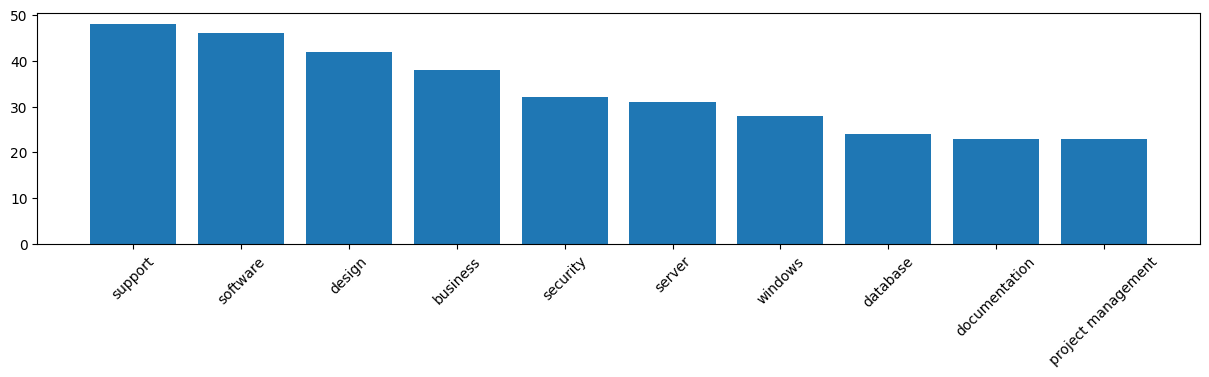

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation =45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [28]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[43]

In [29]:
doc = nlp(text)

In [30]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [31]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

## 7. Let's load the PDF - add some realism

In [32]:
from PyPDF2 import PdfReader
#pip install PyPDF2

reader = PdfReader("../../data/someone_cv.pdf")
page = reader.pages[0] #first page just for demo
text = page.extract_text() 

In [33]:
text = preprocessing(text)

In [34]:
doc = nlp(text)

In [35]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

In [36]:
#last thing i go to assignment
#collect all the skill and put it into a list

skills = []

for ent in doc.ents:
    if ent.label_ == 'SKILL':
        skills.append(ent.text)
        
print(set(skills))

{'engineering', 'deep learning', 'ai', 'algorithms', 'computer science'}


## Extracting education